<a href="https://colab.research.google.com/github/amitmldlai/Implementing-Custom-RandomSearchCV/blob/main/Implementing_Custom_RandomSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [ ]:
x, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

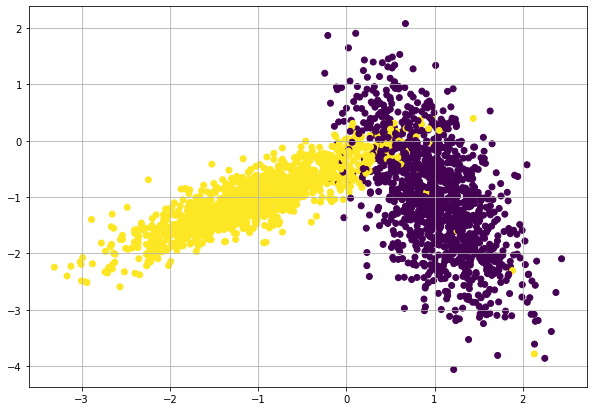

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.scatter(X_test[:, 0], X_test[:, 1], c=[y_test])
plt.grid()
plt.show()

# Implementing Custom RandomSearchCV with k fold cross validation on KNN

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [ ]:
def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
  value_param_range = random.sample(range(1, param_range), 10)
  train_scores, cv_scores = list(), list()
  classifier_param_values = {'n_neigh': sorted(value_param_range)}

  for k in tqdm(classifier_param_values['n_neigh']):
      trainscores_each_folds, cvscores_each_folds = list(), list()
      for i in range(0, folds):
        num_of_elements_in_each_fold = int(len(x_train) / folds)

        test_indices = list(set(list(range((num_of_elements_in_each_fold * i), (num_of_elements_in_each_fold*(i+1))))))  # separating test and train data for each fold
        train_indices = list(set(list(range(0, len(x_train)))) - set(test_indices))

        x_train_fold = x_train[train_indices]
        y_train_fold = y_train[train_indices]
        x_test_fold = x_train[test_indices]
        y_test_fold = y_train[test_indices]

        classifier.n_neighbors = k

        classifier.fit(x_train_fold, y_train_fold)  # fitting train data for each fold
        y_predicted = classifier.predict(x_test_fold)  
        cvscores_each_folds.append(accuracy_score(y_test_fold, y_predicted))  # appending each fold cv accuracy to cvscores_each_folds

        y_predicted = classifier.predict(x_train_fold)
        trainscores_each_folds.append(accuracy_score(y_train_fold, y_predicted))  # appending each fold train accuracy to trainscores_each_folds

      train_scores.append(np.mean(np.array(trainscores_each_folds)))  # calculating mean train accuracy across each fold for each k value 
      cv_scores.append(np.mean(np.array(cvscores_each_folds)))  # calculating mean cv  accuracy across each fold for each k value 

  return train_scores, cv_scores, classifier_param_values

In [ ]:
hyperparameter_range = 50
folds = 3
knn = KNeighborsClassifier()

trainscores, cvscores, classifier_param_values = RandomSearchCV(X_train, y_train, knn, hyperparameter_range, folds)

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Plot for Accuracy-Hyperparamater

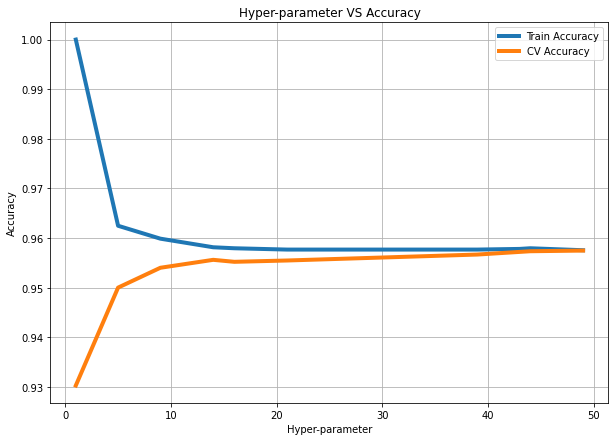

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(classifier_param_values['n_neigh'], trainscores, linewidth=4, label='Train Accuracy')
plt.plot(classifier_param_values['n_neigh'], cvscores, linewidth=4,  label='CV Accuracy')
plt.title('Hyper-parameter VS Accuracy')
plt.xlabel('Hyper-parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Decision Boundary view

In [ ]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

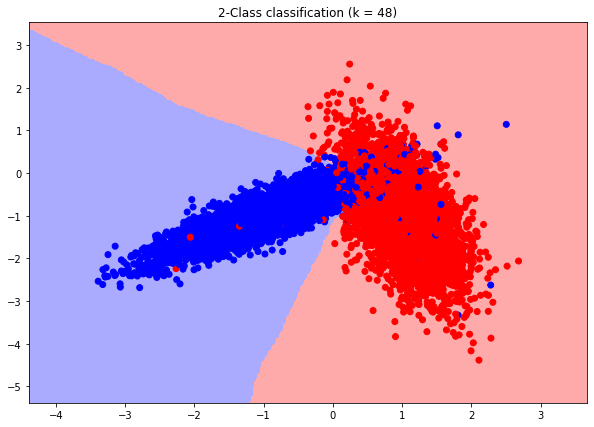

In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 48)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)